# Error Propagation using Random Gaussian Numbers

Example calculation of propagating uncertainties, both when adding and multiplying number, and also in the general case. The propagation can be done both analytically (using the error propagation formula) and also using simulation.

The example is based on FIRST doing the error propagation **analytically**, and then verifying it by running a so-called Monte-Carlo (MC) program, which uses random numbers for propagating errors.

## References:
- Barlow: page 48-61
- Bevington: page 36-48

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   10th of November 2025

***

DO THE FOLLOWING ANALYTICAL EXERCISE FIRST!!!

1. A class of students estimate by eye, that the length of the table in Auditorium A is $L = (3.5\pm 0.4)$m, and that the width is $W = (0.8\pm 0.2)$m.

   Assuming first that there is no correlation between these two measurements, calculate ANALYTICALLY what the Perimeter (P), area (A), and diagonal (D) length is including (propagated) uncertainties. Repeat the calculation, given that the correlation between length and width is $\rho(L,W) = 0.5$ - not an unreasonable number, given that they are estimated by the same (uncertain) scale.
   
NOTE: This is a complete standard problem, that you will be asked to solve again and again in the course (and later in life!). For this reason, make sure that you understand how to do it, and become good at doing it reasonably fast.

In [1]:
mu1   =  3.5
sig1  =  0.4
mu2   =  0.8
sig2  =  0.2
rho12 =  0.0           # Correlation parameter!

Check if the correlation is valid:

In [2]:
if not (-1.0 <= rho12 <= 1.0): 
    raise ValueError(f"Correlation factor not in interval [-1,1], as it is {rho12:6.2f}")

### Note on analytic solutions with SymPy:

Python includes symbolic algebra in the package *SymPy*, which is both simple and powerful (and in Python). In addition, printing with Latex can also be included (see below), which (in combination) is very nice.

Below is a SymPy and Latex example with the hope that it will wet your appetite.

In [3]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [4]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,W,P,A,D = symbols("L, W, P, A, D")
dL,dW,dP,dA,dD = symbols("sigma_L, sigma_W, sigma_P, sigma_A, sigma_D")

# Perimeter:
# Define relation, and print:
P = 2*L + 2*W
lprint(latex(Eq(symbols('P'),P)))

# Calculate uncertainty and print:
dP = sqrt((P.diff(L) * dL)**2 + (P.diff(W) * dW)**2)
lprint(latex(Eq(symbols('sigma_P'), dP)))

# Turn expression into numerical functions 
fP = lambdify((L,W),P)
fdP = lambdify((L,dL,W,dW),dP)

# Define values and their errors
vL, vdL = mu1,sig1
vW, vdW = mu2,sig2

# Numerically evaluate expressions and print 
vP = fP(vL,vW)
vdP = fdP(vL,vdL,vW,vdW)
lprint(fr'P = ({vP:.1f} \pm {vdP:.1f})\,\mathrm{{m}}')




# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Error propagation - Simulation

Now we want to try to see, if we can solve the above error propagation problem using simulation. The method is relatively straight forward: You simply take "realistic" values of the input parameters x (here Length (x1) and Width (x2)), calculate the resulting value y (here Perimeter, Area, and Diagonal), and do this many times. The resulting distribution of y should be centered around the value y(x1,x2), and the standard deviation should reflect the uncertainty in y from the uncertainties in the input variables.

This is a much more clumsy way of calculating the uncertainty, but comes with the advantage, that if the resulting uncertainty is not Gaussian, then one can actually see this (i.e. it avoids the assumptions used in the usual error propagation formula).

In [6]:
# First we set the parameters of the program:
N_exp = 10000           # Number of "experiments" (i.e. drawing from random distributions)
save_plots = False
r = np.random
r.seed(42)

#### Producing random numbers with a correlation:

Below we have used the build in Numpy method for producing two random Gaussian numbers with a correation between them.

You can also do this "yourself", see Barlow page 42-44 for method. Essentially, the method is to generate uncorrelated Gaussian numbers, and then "rotating" these, where the amount of rotation controls the correlation wanted.

In [7]:
# Produce random numbers with (a possible) correlation:
cov = np.array([[sig1**2, rho12*sig1*sig2],
                [rho12*sig1*sig2, sig2**2]])
x12_all = np.random.multivariate_normal([mu1, mu2], cov, size=N_exp)

# Now we use the input variables (x1 and x2) to calculate y:
y_all = x12_all[:,0] - 2*x12_all[:,1]         # Silly formula - you have to put this in yourself!

***
Plot both input distribution and resulting 2D-histogram on screen:

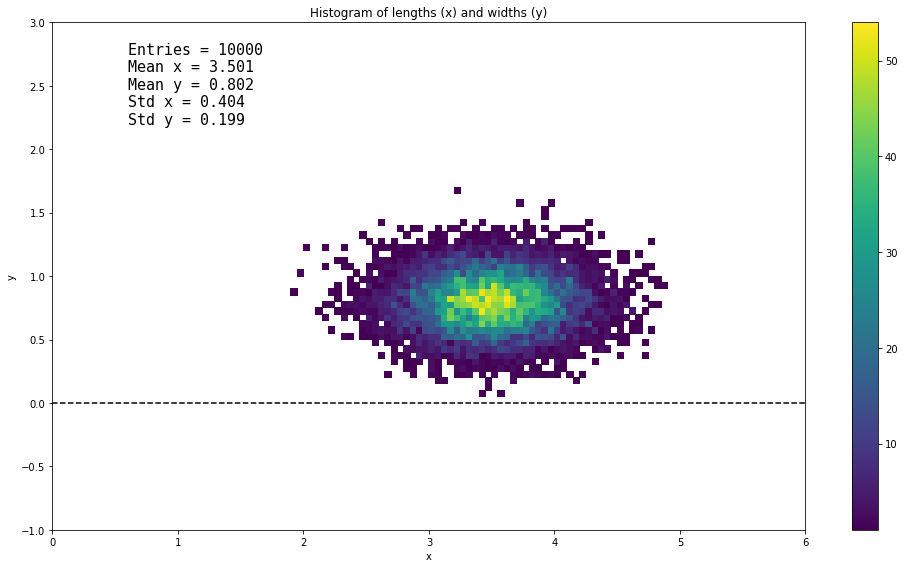

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))
counts, xedges, yedges, im = ax.hist2d(x12_all[:,0], x12_all[:,1], bins=[120, 80], range=[[0.0, 6.0], [-1.0, 3.0]], cmin=1)
ax.plot([0.0, 6.0], [0.0, 0.0], "--k")    # This is a dashed black line from [x1, x2], [y1, y2] with dashed line
fig.colorbar(im)
ax.set(title='Histogram of lengths (x) and widths (y)', xlabel='x', ylabel='y')

plot_info = [f"Entries = {len(x12_all)}",
             f"Mean x = {x12_all[:,0].mean():5.3f}",
             f"Mean y = {x12_all[:,1].mean():5.3f}",
             f"Std x = {x12_all[:,0].std(ddof=1):5.3f}",
             f"Std y = {x12_all[:,1].std(ddof=1):5.3f}"]
ax.text(0.1, 0.8, "\n".join(plot_info), family='monospace', fontsize=15, transform = ax.transAxes);

fig.tight_layout()
fig

if save_plots :
    fig.savefig("Dist_2Dgauss.pdf")

## Looking at the resulting distribution:

Now we look at the `y_all` distribution, which should be Gaussian if the error propagation formula holds:

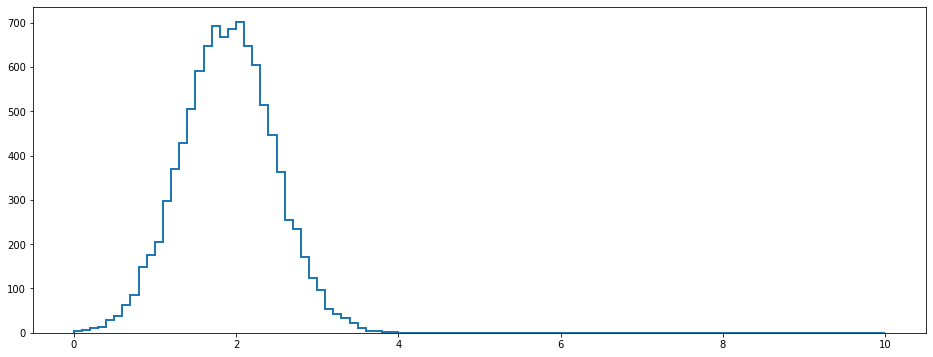

In [9]:
# Always make sure, that you control the binning and range!
nbins = 100
xmin, xmax = 0.0, 10.0
binwidth = (xmax-xmin)/nbins

fig2, ax2 = plt.subplots(figsize=(16, 6));
counts, bin_edges, _ = ax2.hist(y_all, nbins, range=(xmin, xmax), histtype='step', linewidth=2)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)

This is the distribution of "whatever you put into it" (initially x1-2*x2), which shows what output you get and what uncertainty to expect (given by the width - think about this!). We can thus get the result by simply recording the mean and width (SD):

In [10]:
mean = y_all.mean()
std = y_all.std(ddof=1)
print(f"  Mean = {mean:5.3f},    Std = {std:5.3f}")

  Mean = 1.898,    Std = 0.568


However, we are in principle not even sure, if this distribution is Gaussian, so in order to check this, we draw a Gaussian on top using the above mean and standard deviation values.

In [11]:
def gaussian(x, N, mu, sigma):
    return N * binwidth / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)

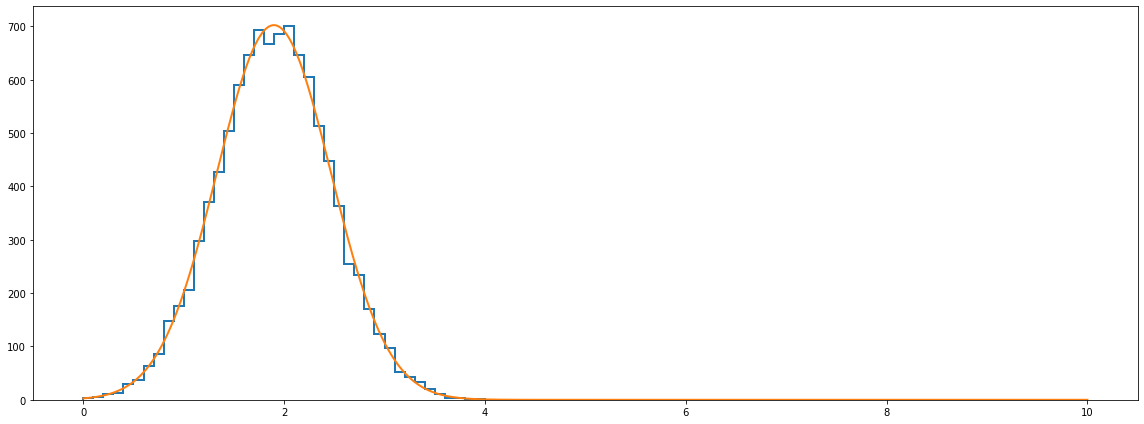

In [12]:
xaxis = np.linspace(xmin, xmax, 1000)
yaxis = gaussian(xaxis, N_exp, mean, std)
ax2.plot(xaxis, yaxis, linewidth=2)
fig2.tight_layout()
fig2

In [13]:
if save_plots:
    fig2.savefig("Dist_ErrorProp.pdf")

---

# Questions:

0. First solve the problem of obtaining the Perimeter, Area & Diagonal with uncertainty ANALYTICALLY.

1. Now look at the program, and assure yourself that you understand what is going on. Put in the correct expression for y in terms of x1=L and x2=W in order to calculate the perimeter, area, and diagonal length, and run the program. Does the output correspond well with the results you expected from your analytical calculations to begin with?

2. Imagine that you wanted to know the central value and uncertainty of y1 and y2, given the
   same above PDFs for `x1`=$L$ and `x2`=$W$:
   
     `y1 = log(square(x1*tan(x2))+sqrt((x1-x2)/(cos(x2)+1.0+x1)))`
     
     `y2 = 1.1+sin(20*x1)`

   Get the central value of y, and see if you can quickly differentiate this with
   respect to `x1` and `x2`, and thus predict what uncertainty to expect for y using
   the error propagation formula. It is (for once) OK to give up on the first expression :-)
   Next, try to estimate the central value and uncertainty using random numbers
   like above - do you trust this result more? And are the distributions Gaussian?


### Advanced questions:

3. Try to generate `x1` and `x2` with non-linear correlation, which yields zero linear correlation,
   and see that despite not having any linear correlation, the result on perimeter, area, and diagonal
   length is still affected.


# Learning points:

Through this exercise, you should understand, that uncertainties (errors in slang) propagation can be in **two ways**:
1. **Analytically**, propergating the uncertainties by differentiating the formula/relation in question.
2. **Numerically** (i.e. simulation), by using random numbers reflecting the uncertainties on the input parameters, and calculating the final resulting number many times from these, noting the variation.

You should be capable of **using both methods** effortlessly and with confidence.

The analytical method is simple and transparent, but not always robust, as it requires that the error propagation formula holds. The numerical method is simple and robust, but not transparent. Using both methods is a great way of cross checking.

Finally, you should understand, that error propagation plays an essential role in science, and that it is also used in planning of experiments (to minimise the error on the final quantity of interest).